## Reproduce figures in the paper for the ATP surveys

In [1]:
base_dir = 'results/atp/'
dir_individual = base_dir + 'model_responses/'
census_dir = base_dir + 'human_responses/'

In [2]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

In [3]:
from plot_utils.models import hf_models, model_names, instruct, model_sizes, openai_models

all_models = sorted(hf_models, key=lambda x: model_sizes[x])
base_models = sorted(list(set(all_models) - set(instruct.keys())), key=lambda x: model_sizes[x])
instruction_models = list(set(instruct.keys()) - set(openai_models))
instruction_models = sorted(instruction_models, key=lambda x: model_sizes[x])

### Load human responses

In [4]:
from scipy.stats import wasserstein_distance

def str2floats(s):
    vs = s[1:-1].split(' ')
    arr = np.array([float(v) for v in vs if len(v) > 1])
    return arr

def get_max_wd(ordered_ref_weights):
    d0, d1 = np.zeros(len(ordered_ref_weights)), np.zeros(len(ordered_ref_weights))
    d0[np.argmax(ordered_ref_weights)] = 1
    d1[np.argmin(ordered_ref_weights)] = 1
    max_wd = wasserstein_distance(ordered_ref_weights, ordered_ref_weights, d0, d1)
    return max_wd

In [5]:
PEW_SURVEY_LIST = [26, 27, 29, 32, 34, 36, 41, 42, 43, 45, 49, 50, 54, 82, 92] 

human_df = []
for wave in PEW_SURVEY_LIST:
    SURVEY_NAME = f'American_Trends_Panel_W{wave}'
    hdf = pd.read_csv(os.path.join(census_dir, f'{SURVEY_NAME}_human.csv'))
    human_df.append(hdf)
human_df = pd.concat(human_df)

variables = list(set(human_df.qkey.unique()))
census_responses = {}
for var in variables:
    s = human_df[(human_df.qkey == var) & (human_df.attribute == 'Overall')].D_H.iloc[0]   
    census_responses[var] = str2floats(s)
    
n_categories = {v: len(census_responses[v]) for v in variables}

### Load model responses

In [6]:
from surveying_llms.load_responses import load_naive_responses, load_adjusted_responses

naive_responses = load_naive_responses(dir_individual, all_models, n_categories, openai_models)
choice_responses, adjusted_responses = load_adjusted_responses(dir_individual, all_models, variables)

# Process to the same number of answer choices as Santurkar, renormalize
adjusted_responses = {v: {m: adjusted_responses[v][m][:n_categories[v]] 
                          for m in all_models} for v in variables}
adjusted_responses = {v: {m: adjusted_responses[v][m] / adjusted_responses[v][m].sum()
                          for m in all_models} for v in variables}

Loading naive responses...


100%|██████████| 33/33 [00:01<00:00, 20.02it/s]


Loading adjusted responses...


100%|██████████| 33/33 [01:12<00:00,  2.21s/it]


In [7]:
from plot_utils.plot_utils import compute_entropy, compute_kl

uniform_responses = {var: np.ones(n_categories[var]) / n_categories[var] for var in variables}
uniform_entropies = {var: compute_entropy(uniform_responses[var]) for var in variables}
census_norm_entropies = {v: compute_entropy(census_responses[v]) / uniform_entropies[v] for v in variables}
naive_norm_entropies = {v: {m: compute_entropy(naive_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}
adjusted_norm_entropies = {v: {m: compute_entropy(adjusted_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}

kl_uniform_census = {v: compute_kl(uniform_responses[v], census_responses[v]) for v in variables}
adjusted_kl_census = {v: {m: compute_kl(adjusted_responses[v][m], census_responses[v])
                   for m in all_models} for v in variables}
adjusted_kl_uniform = {v: {m: compute_kl(adjusted_responses[v][m], uniform_responses[v])
                   for m in all_models} for v in variables}

/Users/rdo/Desktop/surveying-language-models/plot_utils/plot_utils.py:41: RuntimeWarning: divide by zero encountered in divide
  return np.sum(pnz * np.log2(pnz / qnz))


### A-bias

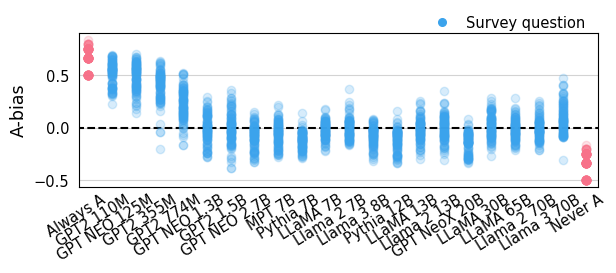

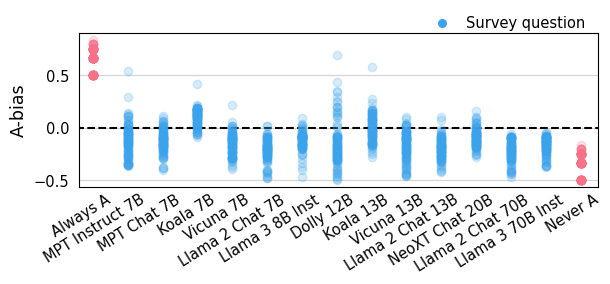

In [8]:
from plot_utils.plot_utils import plot_a_bias

variables_ = np.random.choice(variables, 100, replace=False)  # randomly sample 100 variables, otherwise too many to plot

a_bias = {m: [choice_responses[v][m][0] - (1. / n_categories[v]) for v in variables_] for m in base_models}
a_bias['alwaysA'] = [1. - (1. / n_categories[v]) for v in variables_]
a_bias['neverA'] = [0. - (1. / n_categories[v]) for v in variables_]
model_names_A = {'alwaysA': 'Always A', 'neverA': 'Never A', **model_names}

plot_a_bias(a_bias, ['alwaysA'] + base_models + ['neverA'], model_names_A, figsize=(6.7, 2), alpha=0.2, fontsize=10.5)
plt.plot([-10, 100], [0, 0], 'k--', zorder=1, linewidth=1.5)
plt.savefig('plots/a_bias_atp.pdf', bbox_inches='tight')

a_bias = {m: [choice_responses[v][m][0] - (1. / n_categories[v]) for v in variables_] for m in instruction_models}
a_bias['alwaysA'] = [1. - (1. / n_categories[v]) for v in variables_]
a_bias['neverA'] = [0. - (1. / n_categories[v]) for v in variables_]

plot_a_bias(a_bias, ['alwaysA'] + instruction_models + ['neverA'], model_names_A, figsize=(6.7, 2), alpha=0.2, fontsize=10.5)
plt.plot([-10, 100], [0, 0], 'k--', zorder=1, linewidth=1.5)
plt.savefig('plots/a_bias_instruct_atp.pdf', bbox_inches='tight')

### Figure 4  and Figure 5a

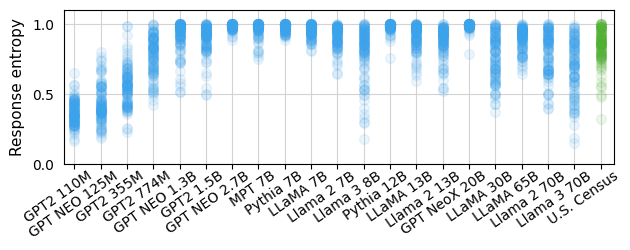

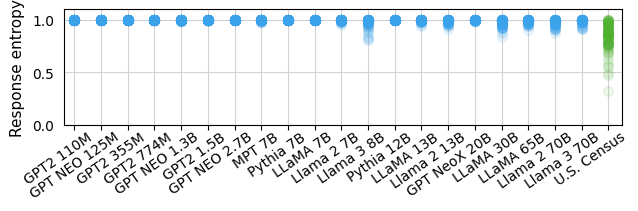

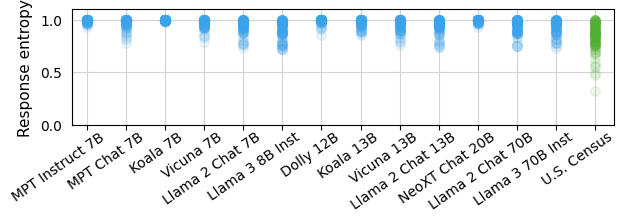

In [9]:
from plot_utils.plot_utils import plot_adjusted_entropy

census_norm_entropies_ = {k:v for k, v in census_norm_entropies.items() if k in variables_}
plot_adjusted_entropy(naive_norm_entropies, census_norm_entropies_, 
                      base_models, variables_, model_names, figsize=(7.1, 2), alpha=0.1, fontsize=10.)
plt.savefig('plots/unadjusted_entropy_atp.pdf', bbox_inches='tight')

plot_adjusted_entropy(adjusted_norm_entropies, census_norm_entropies_, 
                      base_models, variables_, model_names, figsize=(7.2, 1.5), ylegend=1.3, alpha=0.1, fontsize=10)
plt.savefig('plots/adjusted_entropy_atp.pdf', bbox_inches='tight')

plot_adjusted_entropy(adjusted_norm_entropies, census_norm_entropies_, 
                      instruction_models, variables_, model_names, figsize=(7, 1.5), ylegend=1.3, alpha=0.1, fontsize=10)
plt.savefig('plots/adjusted_entropy_ft_atp.pdf', bbox_inches='tight')

### Alignment to different subgroups

In [10]:
df_groups = human_df.attribute + human_df.group

def get_state_responses(state):
    responses = {}
    state_data = human_df[df_groups == state]
    for var in variables:
        var_data = state_data[state_data.qkey == var]
        if len(var_data) > 0:
            var_data = var_data.D_H.iloc[0]
            responses[var] = str2floats(var_data)
    return responses

states = list(set(df_groups.unique()) - set(['OverallOverall']))

# Get the responses of every state
response_overall = get_state_responses('OverallOverall')
responses_states = {s: get_state_responses(s) for s in states}

In [11]:
def alignment(p1, p2):
    d = [i+1 for i in range(p1.size)]
    return 1 - wasserstein_distance(d, d, p1, p2) / get_max_wd(d)

uniform_alignment = {m: np.mean([alignment(adjusted_responses[v][m], uniform_responses[v])
                                   for v in response_overall.keys()]) for m in all_models}
overall_alignmen = {m: np.mean([alignment(adjusted_responses[v][m], rv)
                                   for v, rv in response_overall.items()]) for m in all_models}

print('Computing alignment from models to subgroups...')
subgroup_alignment = {}
for m in tqdm(all_models):
    subgroup_alignment[m] = {s: np.mean([alignment(adjusted_responses[v][m], rs) 
                                 for v, rs in rs.items()]) for s, rs in responses_states.items()}

Computing alignment from models to subgroups...


100%|██████████| 33/33 [03:20<00:00,  6.08s/it]


In [12]:
print('Computing alignment from models to subgroups...')
unad_subgroup_alignment = {}
for m in tqdm(all_models):
    unad_subgroup_alignment[m] = {s: np.mean([alignment(naive_responses[v][m], rs) 
                                 for v, rs in rs.items()]) for s, rs in responses_states.items()}

Computing alignment from models to subgroups...


100%|██████████| 33/33 [02:50<00:00,  5.15s/it]


In [13]:
subgroup_ent = {c: [] for c in states}
for s, rs in responses_states.items():
    for v, rs in rs.items():
        u = np.ones(rs.size) / rs.size
        subgroup_ent[s].append(compute_entropy(rs) / compute_entropy(u))
subgroup_ent = {c: np.mean(subgroup_ent[c]) for c in states}

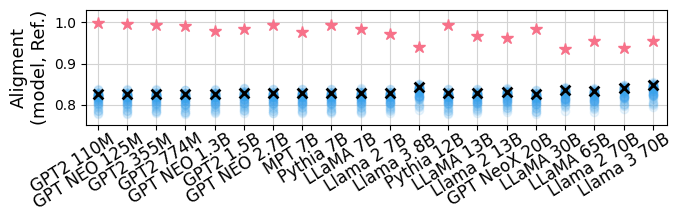

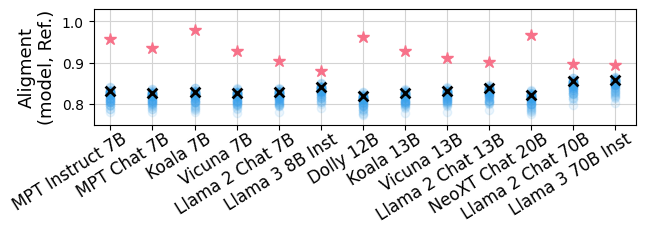

In [14]:
from plot_utils.plot_utils import plot_divergence_subgroups

plot_divergence_subgroups(subgroup_alignment, uniform_alignment, overall_alignmen, base_models, model_names, 
                          figsize=(7.5, 1.5))
plt.ylim([0.75, 1.03])
plt.yticks([0.8, 0.9, 1.0])
plt.ylabel('Aligment\n(model, Ref.)')
plt.savefig('plots/adjusted_kl_subgroups_base_atp.pdf', bbox_inches='tight')

plot_divergence_subgroups(subgroup_alignment, uniform_alignment, overall_alignmen, instruction_models, model_names, 
                          figsize=(7, 1.5))
plt.ylim([0.75, 1.03])
plt.yticks([0.8, 0.9, 1.0])
plt.ylabel('Aligment\n(model, Ref.)')
plt.savefig('plots/adjusted_kl_subgroups_inst_atp.pdf', bbox_inches='tight')

### Figure 9a

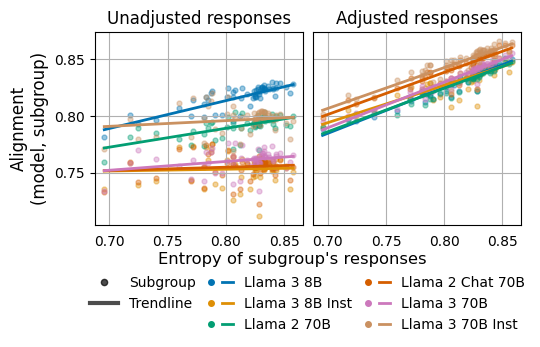

In [15]:
from plot_utils.plot_utils import plot_similarity_opinions

states = responses_states.keys()

models_of_interest = [
    'llama3-8b',
    'llama3-8b-instruct',
    'llama2-70b',
    'llama2-70b-chat',
    'llama3-70b',
    'llama3-70b-instruct',
]

plot_similarity_opinions(states, unad_subgroup_alignment, subgroup_alignment,
                         subgroup_ent, models_of_interest, model_names,
                             xlabel='Entropy of subgroup\'s responses', 
                             ylabel='Alignment\n(model, subgroup)',
                             title1='Unadjusted responses', title2='Adjusted responses')
plt.savefig('plots/lin-trend-atp.pdf', bbox_inches='tight')